### AULA 1

# Detectando atividades fraudulentas

**Situação**:   
Recebo um conjunto de dados de uma empresa que administra um site de comércio eletrônico. Ele contém informações sobre as primeiras transações de muitos usuários diferentes, bem como se um determinado usuário passou a realizar uma atividade fraudulenta ou não.

**Objetivos**:   
* Determinar o país de todos os usuários com base em seus endereços IP;
* Construir um modelo que prevê a probabilidade de que a primeira transação de um novo usuário seja fraudulenta. Explique como diferentes suposições sobre o custo de falsos positivos versus falsos negativos impactam o modelo.
* Explique ao seu chefe (que não é técnico em tudo!) como o modelo está fazendo previsões e por que eles deveriam confiar nele. Faça isso do ponto de vista do usuário, ou seja, descreva que tipo de usuários tem maior probabilidade de ser classificado em risco, quais são suas características, por que isso é razoável? Seu chefe tem medo de que você possa recusar os clientes pagantes válidos por acidente com essa ferramenta.
* Se o seu modelo estiver agora ativo e fazendo previsões em tempo real, descreva como ele deve ser usado a partir de uma perspectiva de produto, ou seja, que tipo de experiência de usuário você recomendaria que fosse criado com base na saída do modelo?



**Resultados**:
* As características mais importantes na detecção de fraudes foram determinadas como:
    * A velocidade na qual eles se movimentaram por todo o funil de vendas (da inscrição à compra)
    * Se ou não vários IDs de usuário foram gerados a partir de um único dispositivo ou endereço IP
* Acontece que nem todos os endereços IP no conjunto de dados podem ser rastreados para um país de origem. Não está claro se a lista de países e os limites de endereços IP estão incompletos, alguns endereços IP foram falsificados ou ocorreu um erro ao registrar o endereço IP. Independentemente, o país de origem não desempenha um papel significativo na determinação de fraudadores, por isso não importa realmente.
* Eu construí dois modelos:
    * Floresta de isolamento: um alogoritmo supervisionado baseado na análise de quantas divisões em recursos são necessárias para isolar uma determinada amostra.
    * Uma máquina de vetores de suporte de classe: um algoritmo não supervisionado baseado no aprendizado de um limite de decisão envolvendo dados não anômalos e, em seguida, tentando identificar anomalias determinando sua distância a partir desse limite.   
* É importante identificar corretamente o comportamento fraudulento quando ele surge (queremos uma alta precisão) e não sinalizar os usuários normais como fraudulentos, alienando, assim, nossa base de clientes (queremos um recall alto). Para otimizar a precisão e a recordação simultaneamente, decidi otimizar a pontuação F1, a média harmônica de precisão e recuperação, em vez de precisão. Usando esse método de otimização, descobri que **a floresta de isolamento tem um desempenho melhor do que a classe SVM**. Embora o SVM tenha pontuações de precisão, recordação e F1 comparáveis à floresta de isolamento, ele não é tão flexível quanto a floresta de isolamento ao lidar com dados multimodais não gaussianos.


**Explicação não técnica**:   

Embora os dois modelos desenvolvidos abordem o problema de maneira diferente, ambos estão tentando determinar qual é o comportamento "normal" do usuário em termos de quanto um usuário "normal" gasta, com que velocidade ele se move através do funil de vendas, sua idade, etc. são todos representados por números e esses números tenderão a ser valores um pouco semelhantes para usuários "normais". Para usuários fraudulentos, alguns desses números podem ser bem diferentes e é esse desvio do comportamento "normal" que esses modelos estão tentando descobrir. Os modelos aproveitam esses números e técnicas estatísticas avançadas para também caracterizar, com números, o quão diferente é um comportamento fraudulento do usuário de um usuário "normal". Usando essas técnicas, descobri que os usuários com maior probabilidade de serem classificados como um risco por esses modelos são aqueles que:
1. ter vários IDs de usuário associados a um único dispositivo ou endereço IP
2. passar de inscrição para compra em períodos extremamente curtos de tempo.
    
Para o ponto 1., um usuário pode esquecer seu nome de usuário / senha e, portanto, se inscrever novamente, gerando um novo ID de usuário para o mesmo dispositivo ou endereço IP. No entanto, nesse caso, é altamente provável que apenas um ID de usuário seja usado por vez. Se vários IDs de usuário estiverem em uso simultaneamente, isso pode indicar que alguém configurou um botnet para interagir com o site. Além disso, muitas das atividades fraudulentas no conjunto de dados foram associadas a dispositivos ou endereços IP que utilizam até 10 IDs de usuário. Isso certamente não é algo que um usuário "normal" jamais faria.
    
Para o ponto 2., um período de tempo típico que potencialmente resultaria em uma bandeira vermelha de um desses algoritmos é de 1 a 2 segundos. Um usuário normal leva alguns minutos para simplesmente navegar no site, mesmo que já tenha tomado a decisão de comprar. Esse tempo é estendido se o usuário tiver que tomar alguma decisão sobre sua compra. Se todo o funil de vendas estiver sendo percorrido literalmente em 1 a 2 segundos, isso é novamente um sinal provável de que, na verdade, é um bot de algum tipo interagindo com o site.

    
**Recomendações**:   
Eu recomendo implementar o modelo de floresta de isolamento em produção. Eu também tenho duas recomendações específicas para a equipe de experiência do usuário e uma para a equipe de segurança.

1. Certifique-se de exigir o nome completo e endereço de e-mail de um usuário para se inscrever. Quando um usuário esquecer seu nome de usuário / senha, dê a ele um caminho fácil de seguir para ** redefinir ** sua senha e exigir seu nome completo e endereço de e-mail para fazer isso. Dessa forma, o ID do usuário original do usuário pode ser encontrado no banco de dados e excluído antes de fornecer um novo ID de usuário. Isso minimiza as chances de um usuário normal ter vários IDs de usuário e reduz as chances de confundi-los com um fraudador.
2. Depois que um usuário se inscrever, apresente imediatamente ofertas / descontos em potencial, se possível. Isso pode ser anunciado como um simples agradecimento por você se inscrever, mas, para usuários normais, aumentará as chances de compra e, ao mesmo tempo, dará a eles algo a considerar, diminuindo um pouco a velocidade deles, dificultando confundi-los com eles. um bot que provavelmente ignoraria todas as ofertas de descontos.
3. Finalmente, também recomendo enfaticamente a segurança durante as primeiras três semanas do ano, pois parece haver um pico de atividade fraudulenta durante esse período.

Primeiro, vou listar todas as importações



In [1]:
# Importando análise
import numpy as np
import pandas as pd
from scipy import special
from random import sample

# Importações diversas
import itertools
from datetime import timedelta
from IPython.display import display

# Miscellaneous settings
pd.options.display.max_seq_items = 2000

## LENDO OS DADOS - LIMPEZA

In [2]:
# Lendo os dados
fraud_df = pd.read_csv("Fraud_Data.csv", header=0)

# Lendo dados do Fornecedor de Acesso à Internet 
ISP_df = pd.read_csv("IpAddress_to_Country.csv", header=0)

### Dados de fraude
Primeiro, verifique o formato das colunas no dataset.

In [3]:
fraud_df.dtypes

id                  int64
cadastro           object
compra             object
valor               int64
id_dispositivo     object
fonte              object
browser            object
genero             object
idade               int64
ip                float64
fraude              int64
dtype: object

Verificar valores nulos

In [4]:
# Verificar valores nulos
print("Checando valores nulos")
for col in fraud_df.columns:
    print("# de valores nulos em {}: {}".format(col, fraud_df[col].isnull().sum()))

Checando valores nulos
# de valores nulos em id: 0
# de valores nulos em cadastro: 0
# de valores nulos em compra: 0
# de valores nulos em valor: 0
# de valores nulos em id_dispositivo: 0
# de valores nulos em fonte: 0
# de valores nulos em browser: 0
# de valores nulos em genero: 0
# de valores nulos em idade: 0
# de valores nulos em ip: 0
# de valores nulos em fraude: 0


Finalmente, veja algumas estatísticas descritivas

In [5]:
fraud_df.describe()

,id,valor,idade,ip,fraude
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


### Dados do Fornecedor de Acesso à Internet 
Primeiro, verifique o formato das colunas no conjunto de dados.

In [6]:
for col in ISP_df.columns:
    print("{}: {}".format(col, ISP_df[col].dtype))

limite_inferior_ip: float64
limite_superior_ip: int64
pais: object


Não está claro se o limite inferior para o endereço IP é realmente um float, ou seja, tem decimais diferentes de zero, ou é apenas um inteiro com um decimal zero.

In [7]:
ip_floats = ISP_df.limite_inferior_ip.apply(lambda x: not x.is_integer()).sum()
print("Número de limites inferiores de endereço IP decimal não-zero: {}".format(ip_floats))

Número de limites inferiores de endereço IP decimal não-zero: 0


É apenas um monte de inteiros com zero decimais, então eu vou converter toda a série para int64.

In [8]:
ISP_df.limite_inferior_ip = ISP_df.limite_inferior_ip.astype(int)

Só para ter certeza, também verificarei valores nulos

In [9]:
# Check for nulls
print("Checando valores nulos")
for col in ISP_df.columns:
    print("# de valores nulos em {}: {}".format(col, ISP_df[col].isnull().sum()))

Checando valores nulos
# de valores nulos em limite_inferior_ip: 0
# de valores nulos em limite_superior_ip: 0
# de valores nulos em pais: 0


Finalmente, vou dar uma olhada em algumas estatísticas descritivas.

In [10]:
ISP_df.describe()

,limite_inferior_ip,limite_superior_ip
count,1.388460e+05,1.388460e+05
mean,2.724532e+09,2.724557e+09
std,8.975215e+08,8.974979e+08
min,1.677722e+07,1.677747e+07
25%,1.919930e+09,1.920008e+09
50%,3.230887e+09,3.230888e+09
75%,3.350465e+09,3.350466e+09
max,3.758096e+09,3.758096e+09


O min dos limites inferior e superior é separado por 25, o que parece razoável para mim. No entanto, o máximo de ambos os limites inferior e superior são iguais, o que definitivamente parece estranho. Existe uma única instância em que os limites inferior e superior são iguais?

In [11]:
display(ISP_df[ ISP_df.limite_inferior_ip == ISP_df.limite_inferior_ip.max() ])
display(ISP_df[ ISP_df.limite_superior_ip == ISP_df.limite_superior_ip.max() ])

,limite_inferior_ip,limite_superior_ip,pais
138845,3758096128,3758096383,Australia


,limite_inferior_ip,limite_superior_ip,pais
138845,3758096128,3758096383,Australia


Ok, foi apenas um alarme falso. Os decimais finais não mostrados na saída de descrição diferem um do outro, então tudo parece estar bem.

## Endereços de IP faltando

Comparando as estatísticas descritivas de cada conjunto de dados (como pode-se ver novamente abaixo), notei que o endereço IP mínimo (max) no conjunto de dados de fraude é menor (maior) que o endereço IP mínimo (máximo) no conjunto de dados ISP. 

In [12]:
ISP_df.describe()

,limite_inferior_ip,limite_superior_ip
count,1.388460e+05,1.388460e+05
mean,2.724532e+09,2.724557e+09
std,8.975215e+08,8.974979e+08
min,1.677722e+07,1.677747e+07
25%,1.919930e+09,1.920008e+09
50%,3.230887e+09,3.230888e+09
75%,3.350465e+09,3.350466e+09
max,3.758096e+09,3.758096e+09


In [13]:
fraud_df.describe()

,id,valor,idade,ip,fraude
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


Isso definitivamente criará problemas ao criar um mapa. Também é possível que alguns endereços IP no conjunto de dados de fraude não estejam no conjunto de dados do ISP, mesmo que estejam dentro do mínimo e máximo do conjunto de dados do ISP. Seria útil saber as contagens associadas a cada um desses erros e também saber quantos endereços IP têm um país exclusivo atribuído a eles.

In [52]:
def isp_counts(isp):
    pais = ISP_df[(ISP_df.limite_inferior_ip <= isp) & (ISP_df.limite_superior_ip >= isp)].pais
    if pais.shape[0] == 1:
        return print("Unico")
    elif pais.shape[0] > 1:
        return print("Vários países")
    elif pais.shape[0] == 0:
        if isp > ISP_df.limite_superior_ip.max():
            return print("Muito grande")
        elif isp < ISP_df.limite_inferior_ip.min():
            return print("Muito pequeno")
        else:
            return print("Faltando")
        
ip_counts = fraud_df.ip.apply(isp_counts)
ip_counts.value_counts()

Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Muito grande
Unico
Unico
Muito pequeno
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Uni

Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Uni

Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito pequeno
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Un

Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Un

Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Faltando
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Un

Unico
Unico
Muito grande
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Muito grande
U

Muito grande
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico

Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Uni

Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico


Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Un

Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito pequeno
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito pequeno

Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito pequeno
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
U

Unico
Muito grande
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Faltando
Unico
Unico
Unico
Muito gr

Muito grande
Unico
Muito grande
Unico
Muito grande
Unico
Muito grande
Faltando
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Muito grande
Muito grande
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Uni

Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Muito grande
Unico
Muito grande
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Faltando
Unico
Muito grande
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Un

Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico

Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Muito pequeno
Muito grande


Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito pequeno
Unico
Muito grande
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Faltando
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Faltando
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unic

Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Faltando
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
U

Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Faltando
Faltando
Unico
Unico
Unico

Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Muito grande
Muito grande
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Faltando
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Faltando
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Faltando
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico


Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Muito grande
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Uni

Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito

Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Faltando
Unico
Unico
Faltando
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unic

Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Mui

Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Faltando
Muito grande
Muito grande
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Mui

Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito pequeno
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico

Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito pequeno
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando

Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito pequeno
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
U

Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito pequeno
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Faltando
Unico
Unico
Faltando
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unic

Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Uni

Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito pequeno
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grand

Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Faltando
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito pequeno
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unic

Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unic

Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito pequeno
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Un

Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Muito grande
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito pequeno
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito pequeno
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande

Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Faltando
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Muito grande
Uni

Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Uni

Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Muito grande
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito pequeno
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Un

Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito pequeno
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Muito pequeno
Unico
Muito grande
Unico
Unico
Faltando
Un

Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Muito pequeno
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Uni

Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Faltando
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Faltando
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
U

Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Faltando
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Un

Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Muito pequeno
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico


Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito pequeno
Muito grande
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Muito grande
Faltando
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
U

Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Faltando
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Uni

Muito grande
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unic

Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Mu

Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito pequeno
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Faltando
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito pequeno
Unico
Muito grande
Faltando
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
U

Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Muito grande
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
U

Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Muito grande
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Un

Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Muito grande
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Muit

Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Muito grande
Unico


Muito grande
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Faltando
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico


Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Muito pequeno
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Uni

Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito pequeno
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito pequeno
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Faltando
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico


Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Muito grande
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico

Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito pequeno
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unic

Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Faltando
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Muito pequeno
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Falt

Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito pequeno
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Faltando
Muito grande
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Faltando
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito pequeno
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico

Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito pequeno
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Muito grande
Muito grande
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Muito grande

Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Un

Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Muito grande
Unico
Faltando
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito pequeno
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito pequeno
Unico
Unico
Unico
Muito grande
Unico
Unico
U

Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito pequeno
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico


Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Faltando
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito pequeno
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito pequeno
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande


Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico


Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Faltando
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unic

Muito pequeno
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito pequeno
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Mui

Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Faltando
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Muito grande
Unico
Muito pequeno
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muit

Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Muito grande
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
U

Muito grande
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Faltando
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Muito pequeno
Faltando
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico


Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Muito grande
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Muito

Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Muito grande
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Uni

Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Muito grande
Unico
Muito grande
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Muito g

Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito pequeno
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Muito grande
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Un

Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Muito grande
Muito grande
Unico
Faltando
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico


Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito g

Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico


Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Muito grande
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Faltando
Unico
Uni

Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Faltando
Unico
Unico
Unico
Unico
Muito grande
Unico
Faltando
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Uni

Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito pequeno
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico


Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Muito grande
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Faltando
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito gra

Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Faltando
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico


Unico
Unico
Muito grande
Unico
Muito pequeno
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Faltando
Unico
Unico
Muito pequeno
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande


Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Uni

Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Muito pequeno
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Uni

Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico


Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Uni

Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Faltando
Faltando
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unic

Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Muito pequeno
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito gr

Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Muito pequeno
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico


Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
M

Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Mu

Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Faltando
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Muito grande
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico

Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Faltando
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unic

Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito pequeno
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico

Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Faltando
Unico
Unico
Muito grande
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico


Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Muito grande
Unico
Muito grande
Unico
Muito grande
Faltando
Unico
Unico
Unico
Mu

Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Faltando
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Uni

Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito pequeno
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande

Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito pequeno
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito pequeno
Unico
Unico
Unico
Unico
Unico
Unico
U

Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Faltando
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Muito grande
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Muito grande
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito pequeno
U

Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito pequeno
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Muito grande
Muito grande
Faltando
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito pequeno
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Faltando
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito pequeno
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Muito grande
Unico
Unico
Unico

Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico


Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Faltando
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Un

Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito pequeno
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando


Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Faltando
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito

Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Faltando
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito gr

Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito gran

Muito grande
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Muito pequeno
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito pequeno
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Muito grande
Muito grande
Unico
Unico
Unico
Faltando
Unico
Muito grande
Unico
Unico
Faltando
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Muito grande
Unico
Muito grande
Muito grande
Unico
Muito grande
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Uni

Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Faltando
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unic

Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito pequeno
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico


Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Muito grande
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito pequeno
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico


Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico


Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Faltando
Unico
Unico
Unico
Faltando
Muito grande
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Un

Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Un

Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Muito grande
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito pequeno
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grand

Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Faltando
Unico
Unico
Muito grande
Unico
Unico
Unico
Faltando
Unico
Muito grande
Muito grande
Muito grande
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito pequeno
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Muito grande
Faltando
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Muito grande
U

Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito pequeno
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito pequeno
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Uni

Unico
Unico
Unico
Unico
Muito grande
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unic

Muito grande
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Faltando
Unico
Unico
Muito grande
Faltando
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito gr

Unico
Unico
Unico
Unico
Unico
Muito pequeno
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Uni

Muito grande
Unico
Unico
Muito grande
Unico
Faltando
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico

Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico


Unico
Unico
Unico
Faltando
Unico
Unico
Unico
Unico
Muito pequeno
Unico
Muito grande
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Faltando
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Muito grande
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Muito grande
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico
Unico


Series([], Name: ip, dtype: int64)

Embora a maioria dos endereços IP esteja identificando exclusivamente, há muitos que estão faltando por vários motivos. Os valores ausentes constituem 17% dos dados do endereço IP.   

Embora seja possível descartar apenas linhas com países de origem ausentes, é possível que esses endereços IP ausentes correspondam a endereços falsos gerados especificamente para criar fraudes. Se isso for verdade, devemos esperar que uma correlação associada esteja presente. Por esse motivo, manteremos essas linhas e rotularemos o país de origem como "Faltando".

In [53]:
def ip_to_country(ip):
    tmp_ser = ISP_df[ (ISP_df.limite_inferior_ip <= ip) 
                    & (ISP_df.limite_superior_ip >= ip) ].pais
    if tmp_ser.shape[0] == 1:
        return tmp_ser.iloc[0]
    elif tmp_ser.shape[0] < 1:
        return print("Faltando")
    elif tmp_ser.shape[0] > 1:
        return print("Erro")
    
fraud_df["pais"] = fraud_df.ip.apply(ip_to_country)

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Isso completa a primeira tarefa do desafio. O conjunto de dados de fraude bruto agora tem todas as colunas desejadas.

In [54]:
fraud_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,None
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


Antes de prosseguir, salvarei esta versão do conjunto de dados de fraude para tempos de carregamento mais rápidos.

In [14]:
#fraud_df.to_csv("Fraud_Data_with_Countries.csv", index=False)
fraud_df = pd.read_csv("Fraud_Data_with_Countries.csv", header=0)
fraud_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


### AULA 2

# Visualizações básicas
Aqui eu exibo algumas visualizações básicas para ajudar na compreensão do conjunto de dados. Primeiro, explorarei a correlação entre sexo e classe. Os homens compõem mais a base de clientes da empresa e, portanto, também estão envolvidos em mais casos de fraude. Não parece que um gênero seja mais propenso a participar de fraudes, apenas que um gênero tende a usar o site mais em geral.

In [9]:
# Importando visualização
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0, 0.5, 'Casos')

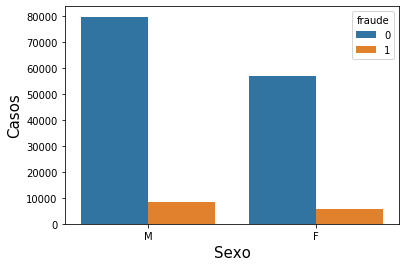

In [57]:
sns.countplot(x='genero', hue='fraude', data=fraud_df)
plt.xlabel("Sexo", fontsize=15)
plt.ylabel("Casos", fontsize=15)

Em seguida, exploro a relação entre valor de compra e fraude. Embora haja um ligeiro aumento no valor médio de compra associado à atividade fraudulenta, as barras de erros são altas demais para detectar uma tendência real.



/home/sarinha/.local/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.42499999999999716, 0.5, 'Valor da compra')

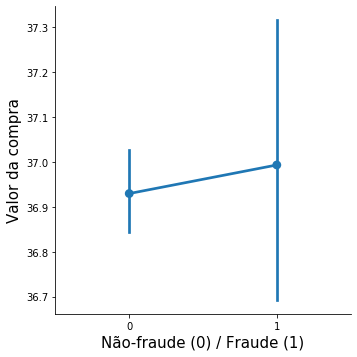

In [58]:
sns.factorplot(x="fraude", y="valor", data=fraud_df)
plt.xlabel("Não-fraude (0) / Fraude (1)", fontsize=15)
plt.ylabel("Valor da compra", fontsize=15)

Em seguida, exploro a relação entre idade e fraude. À primeira vista, parece que pode haver uma tendência útil aqui, mas as idades são, na verdade, muito próximas umas das outras e estão essencialmente bem acima da idade média e média do usuário. Novamente, isso provavelmente não será muito útil.

Text(-5.825000000000003, 0.5, 'Idade')

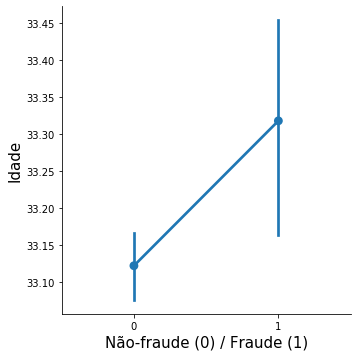

In [59]:
sns.factorplot(x="fraude", y="idade", data=fraud_df)
plt.xlabel("Não-fraude (0) / Fraude (1)", fontsize=15)
plt.ylabel("Idade", fontsize=15)

Em seguida, exploro a relação entre fonte de marketing e fraude. Não parece que qualquer fonte de marketing esteja mais associada a fraudes. Embora existam menos fontes diretas associadas à fraude, há menos fontes diretas no geral e, portanto, a diminuição provavelmente tem mais a ver com o fato de não ser tão bem-sucedida quanto a otimização de mecanismos de pesquisa e anúncios para atrair clientes para o site.

Text(0, 0.5, 'Contagem')

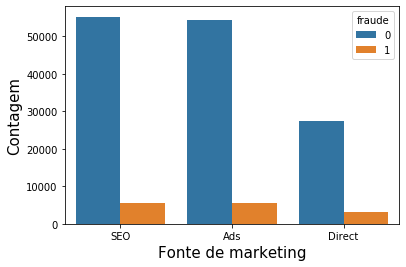

In [60]:
sns.countplot(x='fonte', hue='fraude', data=fraud_df)
plt.xlabel("Fonte de marketing", fontsize=15)
plt.ylabel("Contagem", fontsize=15)

Em seguida, exploro a relação entre o navegador usado e a fraude. Mais uma vez, a contagem de navegadores parece ser mais indicativa de sua relativa popularidade em geral do que de qualquer tendência significativa associada à fraude.

Text(0, 0.5, 'Contagem')

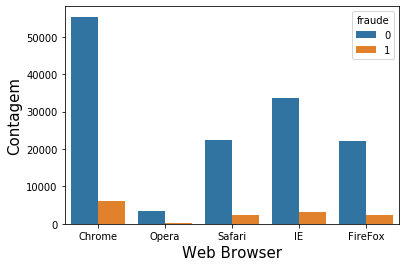

In [61]:
sns.countplot(x='browser', hue='fraude', data=fraud_df)
plt.xlabel("Web Browser", fontsize=15)
plt.ylabel("Contagem", fontsize=15)

Em seguida, exploro a relação entre o país de origem e a fraude. É impossível representar mais de 250 países de uma forma visualmente agradável. Abaixo, exibo um gráfico de barras mostrando a parcela de instâncias anormais pelas quais cada país é responsável. Na maior parte, o gráfico parece representar mais a participação relativa do total de usuários ativos de Internet em todo o mundo em cada país e não necessariamente aqueles associados à fraude. Por exemplo, eu certamente não sinalizaria todos os usuários dos EUA como possíveis fraudadores.

No entanto, a designação "Faltando" parece também ocupar bastante do gráfico de pizza. Por causa disso, pode ser útil examinar mais detalhadamente o efeito do país de origem usando a seleção de recursos.



In [62]:
fraud_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


Text(0, 0.5, 'Países')

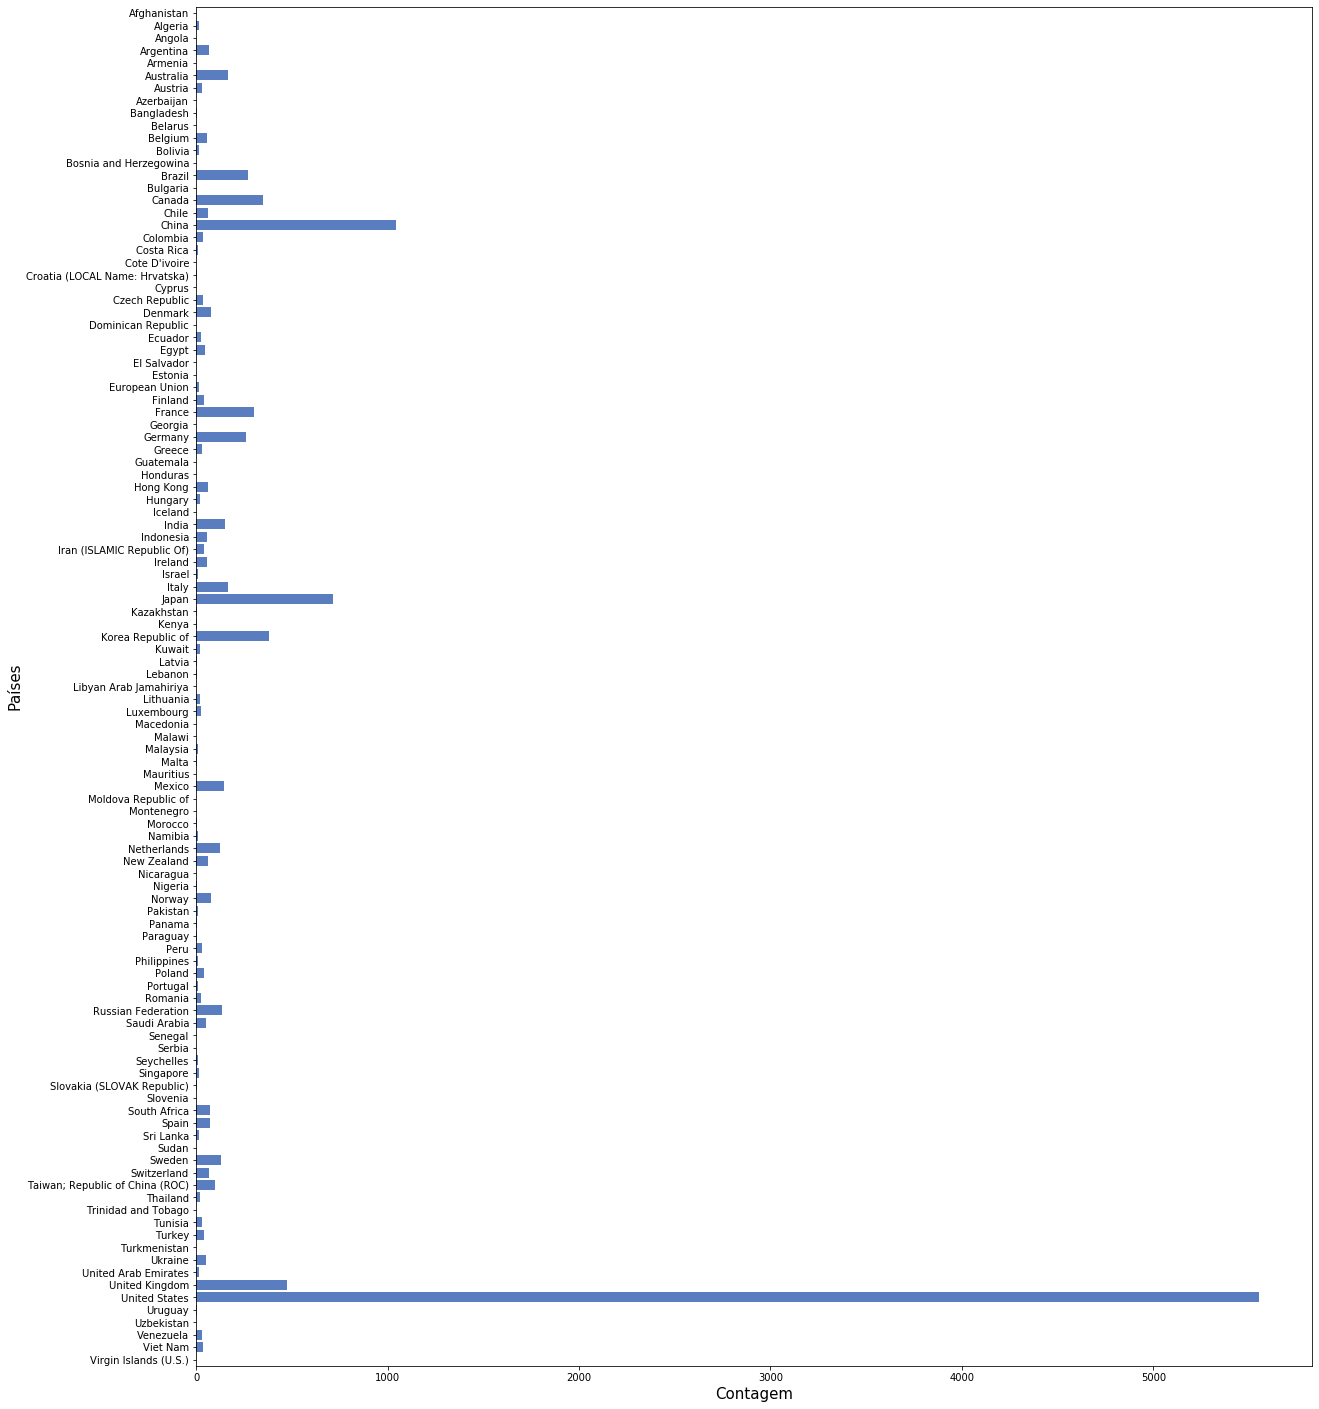

In [63]:
sums_f = fraud_df[fraud_df["fraude"] == 1]["fraude"].groupby(fraud_df.pais).sum()
sums_f = sums_f.to_frame().reset_index()

sums_nf = fraud_df[fraud_df["fraude"] == 0]["fraude"].groupby(fraud_df.pais).sum()
sums_nf = sums_nf.to_frame().reset_index()

f, ax = plt.subplots(figsize=(20, 25))
sns.set_color_codes("muted")
sns.barplot(x="fraude", y="pais", data=sums_f,
            label="Total", color="b")
plt.xlabel("Contagem", fontsize=15)
plt.ylabel("Países", fontsize=15)

Em seguida, exploro a relação entre o número de ids de usuários exclusivos associados a um único dispositivo ou a um único endereço IP. Essas são correlações claramente importantes. Parece que vários IDs de usuário associados a um ID de dispositivo único ou endereço IP é um grande indicador de comportamento fraudulento.

/home/sarinha/.local/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(16.299999999999997, 0.5, 'ID de usuário por endereço IP')

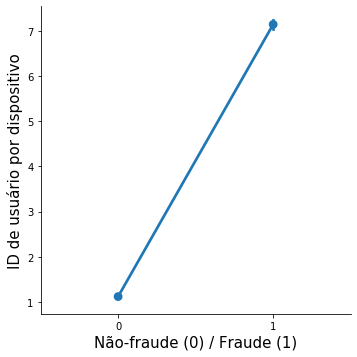

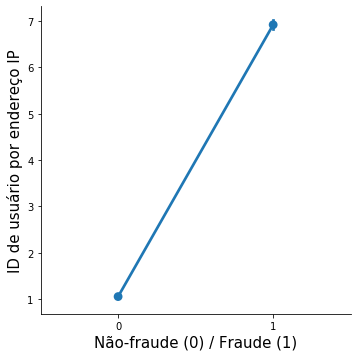

In [15]:
# Inicializando novo dataframe
tmp_df = pd.DataFrame(columns=("fraude", "id_por_dispositivo", "id_por_ip"))
tmp_df["fraude"] = fraud_df["fraude"]

# Contando número e ids únicos por usuário para cada disposiivo 
userid_count = fraud_df.groupby("id_dispositivo").id.count()
tmp_df["id_por_dispositivo"] = fraud_df.id_dispositivo.apply(lambda x: userid_count[x])

# Contando número e ids únicos por usuário para cada ip
userid_count = fraud_df.groupby("ip").id.count()
tmp_df["id_por_ip"] = fraud_df.ip.apply(lambda x: userid_count[x])

sns.factorplot(x="fraude", y="id_por_dispositivo", data=tmp_df)
plt.xlabel("Não-fraude (0) / Fraude (1)", fontsize=15)
plt.ylabel("ID de usuário por dispositivo", fontsize=15)

sns.factorplot(x="fraude", y="id_por_ip", data=tmp_df)
plt.xlabel("Não-fraude (0) / Fraude (1)", fontsize=15)
plt.ylabel("ID de usuário por endereço IP", fontsize=15)

Por fim, exploro a relação entre o tempo entre a inscrição e a compra e a fraude. Estas também são correlações muito claramente importantes. Períodos de tempo extremamente pequenos entre a inscrição e a compra também estão fortemente correlacionados com a fraude.

Text(-8.825000000000003, 0.5, 'Tempo entre início e compra (Segundos)')

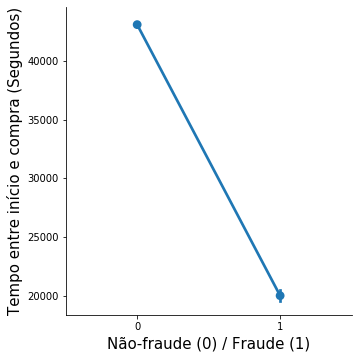

In [69]:
# Converter tempo de inscrição e tempo de compra em objetos de data e hora
tmp_df["cadastro"] = fraud_df.cadastro.apply(pd.to_datetime)
tmp_df["compra"] = fraud_df.compra.apply(pd.to_datetime)

# Adicione colunas para o número de segundos entre os tempos de compra e de inscrição
tmp_df["tempo"] = (tmp_df.compra - tmp_df.cadastro).apply(lambda x: x.seconds)

sns.factorplot(x="fraude", y="tempo", data=tmp_df)
plt.xlabel("Não-fraude (0) / Fraude (1)", fontsize=15)
plt.ylabel("Tempo entre início e compra (Segundos)", fontsize=15)

Em seguida, exploro a relação entre o horário (hora do dia, dia da semana, semana do ano) e fraude. Parece que a fraude ocorre com bastante regularidade ao longo das horas do dia e dias da semana. No entanto, parece que uma grande explosão de fraude ocorre nas primeiras três semanas do ano.

Não sei por que isso acontece. No entanto, não tenho certeza se seria um recurso útil no conjunto de dados, pois muitos clientes normais também visitam o site durante esse período. Eu acho que é mais apropriado simplesmente recomendar fortemente que a equipe de segurança da empresa esteja em alerta máximo para fraudes durante as primeiras três semanas do ano.

In [70]:
tmp_df.head()

,fraude,id_por_dispositivo,id_por_ip,cadastro,compra,tempo
0,0,1,1,2015-02-24 22:55:49,2015-04-18 02:47:11,13882
1,0,1,1,2015-06-07 20:39:50,2015-06-08 01:38:54,17944
2,1,12,12,2015-01-01 18:52:44,2015-01-01 18:52:45,1
3,0,1,1,2015-04-28 21:13:25,2015-05-04 13:54:50,60085
4,0,1,1,2015-07-21 07:09:52,2015-09-09 18:40:53,41461


Text(0, 0.5, 'Contagem')

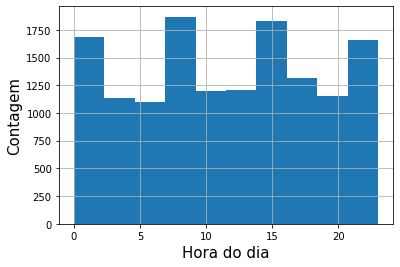

In [111]:
tmp_df[tmp_df["fraude"] == 1].cadastro.apply(lambda x: x.hour).hist()
plt.xlabel("Hora do dia", fontsize=15)
plt.ylabel("Contagem", fontsize=15)

Text(0, 0.5, 'Contagem')

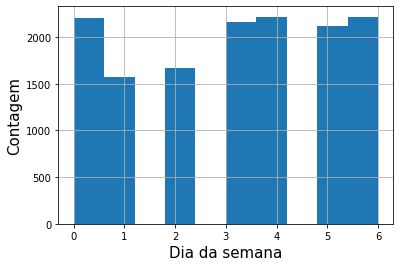

In [71]:
tmp_df[tmp_df["fraude"] == 1].cadastro.apply(lambda x: x.dayofweek).hist()
plt.xlabel("Dia da semana", fontsize=15)
plt.ylabel("Contagem", fontsize=15)

Text(0, 0.5, 'Contagem')

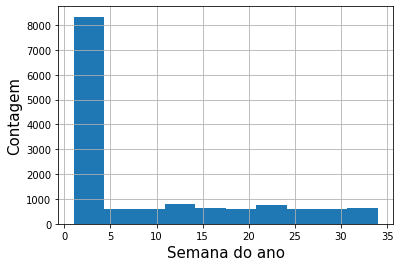

In [72]:
tmp_df[tmp_df["fraude"] == 1].cadastro.apply(lambda x: x.week).hist()
plt.xlabel("Semana do ano", fontsize=15)
plt.ylabel("Contagem", fontsize=15)

Na próxima seção, construo os recursos com base no país de origem, no número de IDs de usuários associados a IDs de dispositivos e endereços IP exclusivos e períodos de tempo entre a inscrição e a compra.

### AULA 3

## Engenharia de recursos   
Aqui, listarei todos os novos recursos que adicionarei nesta seção.
* Vários IDs de usuário para um dispositivo ou endereço IP exclusivo
    * Ambos são igualmente bons indicadores.
    * Eles são altamente correlacionados. Para evitar qualquer multi-colinearidade, gerarei apenas um recurso que será a média do número de IDs de usuários associados ao ID do dispositivo ou ao endereço IP.
* Tempo entre a inscrição e a primeira compra em segundos.
* Recursos com codificação para cada país.

In [2]:
# Primeiro recarregamos o dataset
fraud_df = pd.read_csv("Fraud_Data_with_Countries.csv", header=0)

# Adicione uma coluna correspondente ao número de ID de usuário exclusivo associado ao ID do dispositivo fornecido
userid_count = fraud_df.groupby("id_dispositivo").id.count()
fraud_df["id_por_dispositivo"] = fraud_df.id_dispositivo.apply(lambda x: userid_count[x])

fraud_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais,id_por_dispositivo
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1


In [3]:
# Adicionar coluna correspondente ao número de IDs de usuários exclusivos associados ao endereço IP fornecido
userid_count = fraud_df.groupby("ip").id.count()
fraud_df["id_por_ip"] = fraud_df.ip.apply(lambda x: userid_count[x])

fraud_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais,id_por_dispositivo,id_por_ip
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,1,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1,1


In [4]:
# Adicionar coluna para a média das duas colunas anteriores
fraud_df["media_id"] = (fraud_df.id_por_dispositivo + fraud_df.id_por_ip) * 0.5

fraud_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais,id_por_dispositivo,id_por_ip,media_id
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,1,1.0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,1,1.0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,12,12.0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,1,1,1.0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1,1,1.0


In [5]:
# Converter tempo de inscrição e tempo de compra em objetos de data e hora
fraud_df.cadastro = fraud_df.cadastro.apply(pd.to_datetime)
fraud_df.compra = fraud_df.compra.apply(pd.to_datetime)

# Adicione colunas para o número de segundos entre os tempos de compra e inscrição
fraud_df["tempo"] = (fraud_df.compra - fraud_df.cadastro).apply(lambda x: x.seconds)
fraud_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais,id_por_dispositivo,id_por_ip,media_id,tempo
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,1,1.0,13882
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,1,1.0,17944
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,12,12.0,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,1,1,1.0,60085
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1,1,1.0,41461


In [6]:
# Crie colunas fictícias para o recurso de país
pais_dummies = pd.get_dummies(fraud_df.pais, prefix='pais')
fraud_df = pd.concat([fraud_df, pais_dummies], axis=1)
fraud_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,...,pais_United States,pais_Uruguay,pais_Uzbekistan,pais_Vanuatu,pais_Venezuela,pais_Viet Nam,pais_Virgin Islands (U.S.),pais_Yemen,pais_Zambia,pais_Zimbabwe
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,0,0,0,0,0,0,0,0,0,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,...,1,0,0,0,0,0,0,0,0,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,...,1,0,0,0,0,0,0,0,0,0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,...,0,0,0,0,0,0,0,0,0,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,...,1,0,0,0,0,0,0,0,0,0


In [7]:
# Exclua colunas falsas
fraud_df.drop(["id", 
               "cadastro", 
               "compra", 
               "id_dispositivo", 
               "ip", 
               "id_por_dispositivo",
               "id_por_ip",
               "pais",
               "fonte",
               "browser",
               "genero",
               "idade",
               "valor"
               ], axis=1, inplace=True)

Neste ponto, tenho mais de 150 recursos. Para reduzir isso, vou fazer a seleção de recursos, mas é importante fazer uma seleção de recursos sobre os recursos reais que você usará. Como os algoritmos de detecção de anomalias que usaremos posteriormente se beneficiam de recursos mais gaussianos do que não, primeiro vou transformar os recursos não categóricos.  

O primeiro recurso é o número médio de IDs de usuário. É bi-modal (como mostrado na figura abaixo), com um grande pico em torno de 1-1,5 e, em seguida, uma distribuição gaussiana centrada em torno de 12 com um desvio padrão de aproximadamente 3. Devido à natureza bi-modal, não há nada mais que eu possa fazer para tornar isso mais Gaussiano. Eu vou apenas manter do jeito que é.

![Alt text](https://upload.wikimedia.org/wikipedia/commons/e/e2/Bimodal.png)

/home/sarinha/.local/lib/python3.6/site-packages/pandas/plotting/_core.py:2477: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


Text(0, 0.5, 'Contagem normalizada')

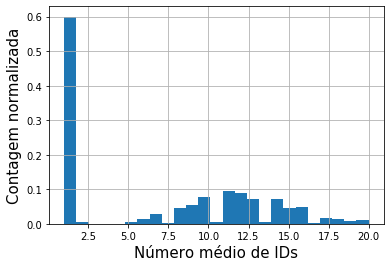

In [10]:
fraud_df[fraud_df["fraude"]==1].media_id.hist(normed=True, bins=25)
plt.xlabel("Número médio de IDs", fontsize=15)
plt.ylabel("Contagem normalizada", fontsize=15)

O recurso tempo é distribuído uniformemente.

Text(0, 0.5, 'Contagem normalizada')

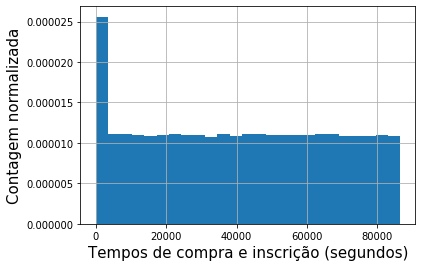

In [11]:
fraud_df.tempo.hist(normed=True, bins=25)
plt.xlabel("Tempos de compra e inscrição (segundos)", fontsize=15)
plt.ylabel("Contagem normalizada", fontsize=15)

Nesse caso temos números aleatórios adistribuidos uniformemente e gostaríamos de transforma-los em números aleatórios distribuídos de forma Gaussiana.

Sendo assim, podemos usar a seguinte transformação:
$$ X = \sqrt{2} \; \text{erf}^{-1} \left( 2 \Phi - 1 \right) $$
em que $\Phi$ é uma variável aleatória uniformemente distribuída, $X$ é uma variável aleatória normalmente distribuída e $\text{erf}^{-1}$ é o inverso da função de erro. No entanto, antes que essa transformação possa ser feita, primeiro preciso normalizar o recurso para ficar entre 0 e 1.


- *FONTE 1: Rosenblatt M. Remarks on a multivariate transformation. Ann. Math. Stat., 1952; 23: 470–472.*

- *FONTE 2: Van Albada SJ, Robinson PA. Transformation of arbitrary distributions to the normal distribu-tion with application to EEG test-retest reliability (2007) J NeurosciMethods 161: 205–21.*


Text(0, 0.5, 'Contagem normalizada')

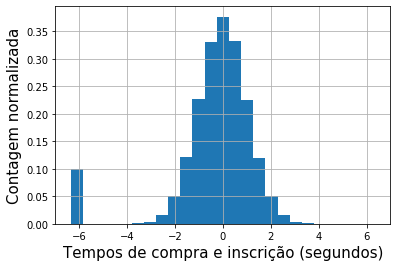

In [12]:
def rescale_series(ser):
    ser_min = ser.min() - 1e-5
    ser_max = ser.max() + 1e-5
    new_ser = (ser - ser_min) / (ser_max - ser_min)
    new_ser = new_ser.apply(lambda x: np.sqrt(2) * special.erfinv(2 * x - 1))
    return new_ser

fraud_df["tempo"] = rescale_series(fraud_df.tempo)
fraud_df.tempo.hist(normed=True, bins=25)
plt.xlabel("Tempos de compra e inscrição (segundos)", fontsize=15)
plt.ylabel("Contagem normalizada", fontsize=15)

Neste ponto, seria possível utilizar funções prontas para escalonamento de dados, como a MinMaxScaler(). Porém, ao usarmos essa função e depois fazer a transformação citada, os valores acima da padronização constam como "inf". Quando faço a função diretamente, os valores permanecem floats. Isso facilita a identificação do que realmente é um outlier ou não. Caso contrário, eu teria que limpar o dataset de novo para remover esses "infs" e isso seria uma outra análise, afinal, o que eles realmente significam? Enquanto eles permanecem numéricos, consigo simplesmente deixar eles lá para ver o que acontece, sem colocar muito a mão humana.

Todos os recursos desejados agora são criados, mas agora os redimensionarei para ficar entre 0 e 1.

In [17]:
def rescale_series(ser):
    ser_min = ser.min()
    ser_max = ser.max()
    new_ser = (ser - ser_min) / (ser_max - ser_min)
    return new_ser

# Obter todos os nomes de coluna que não são codificados
non_onehotencoded_cols = [feature for feature in fraud_df.columns if "pais" not in feature and feature != "fraude"]


# Redimensione todas as colunas não codificadas
for col in non_onehotencoded_cols:
    fraud_df[col] = rescale_series(fraud_df[col])

    
X = fraud_df[ [col for col in fraud_df.columns if col != "fraude"] ]
Y = fraud_df["fraude"]

In [18]:
X.to_csv("X.csv", index=False)
Y.to_csv("Y.csv", index=False)
fraud_df.head()

/home/sarinha/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


,fraude,media_id,tempo,pais_Afghanistan,pais_Albania,pais_Algeria,pais_Angola,pais_Antigua and Barbuda,pais_Argentina,pais_Armenia,...,pais_United States,pais_Uruguay,pais_Uzbekistan,pais_Vanuatu,pais_Venezuela,pais_Viet Nam,pais_Virgin Islands (U.S.),pais_Yemen,pais_Zambia,pais_Zimbabwe
0,0,0.000000,0.421773,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0.000000,0.435753,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1,0.578947,0.000000,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0.000000,0.540331,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0.000000,0.496019,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


No momento, tenho mais de 200 recursos, o que é um pouco demais. Vou realizar a seleção de recursos aqui com um classificador de árvores extras para reduzir esse número.

In [14]:
# Crie uma instância do classificador de árvores extras
clf = ExtraTreesClassifier()
_ = clf.fit(X, Y)

# Crie um dataframe para mapear recursos para suas importâncias
features = pd.DataFrame()
features['feature'] = X.columns
features['importancia'] = clf.feature_importances_

# Imprima recursos importantes
features[ features.importancia > np.mean(features.importancia) ].sort_values(by='importancia', ascending=False)

/home/sarinha/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,feature,importancia
1,tempo,0.743137
0,media_id,0.251308


Parece que o país de origem não importa, afinal. Como existem apenas dois recursos, posso visualizar os dados com bastante facilidade.

Text(27.42466796875, 0.5, 'Número médio de IDs')

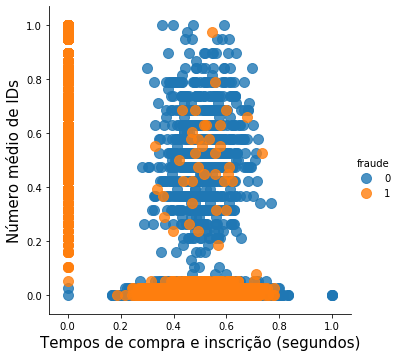

In [15]:
X = fraud_df[ [col for col in fraud_df.columns if "pais" not in col and col != "fraude"] ]

sns.lmplot("tempo", "media_id",
           data=pd.concat([X, Y], axis=1),
           fit_reg=False,
           hue="fraude",  
           scatter_kws={"marker": "D", "s": 100})
plt.xlabel('Tempos de compra e inscrição (segundos)', fontsize=15)
plt.ylabel('Número médio de IDs', fontsize=15)

Os pontos de fraude e não-fraude não estão completamente isolados uns dos outros, então não está claro que tipo de desempenho eu devo esperar. Vamos ver na próxima seção como os modelos funcionam. Antes de prosseguir, vou re-indexar os dados para limpeza.

In [16]:
X.index = range(len(X))
Y.index = range(len(Y))

### AULA 4

## Modelando
Há duas maneiras de abordar a detecção de anomalias a partir de uma perspectiva de modelagem, supervisionada e não supervisionada. Começarei com a abordagem supervisionada em que utilizo um algoritmo de floresta de isolamento.

A floresta de isolamento isola as observações selecionando aleatoriamente um recurso e, em seguida, selecionando recursivamente os valores de divisão aleatória até que a amostra seja isolada. Essa divisão recursiva pode ser representada como uma estrutura de árvore na qual o número de separações é equivalente ao comprimento do caminho do nó raiz até o nó de terminação. Esse comprimento do caminho, em média em uma floresta de árvores geradas de maneira semelhante, é uma medida de normalidade. Quanto menor o comprimento médio do caminho, menor o trabalho necessário para isolar a amostra e maior a probabilidade de a amostra representar uma anomalia.   

Abaixo, realizo uma validação cruzada de 5 vezes com uma pesquisa sobre o número de estimadores na floresta. Como estou interessada em maximizar a precisão e a recordação simultaneamente, marquei cada validação cruzada usando a pontuação F1.

In [31]:
# Importando modelos
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import f1_score

In [17]:
# Dividindo os dados
X_dev, X_eval, Y_dev, Y_eval = train_test_split(X, Y, train_size=.75, random_state=23)
# A floresta de isolamento retorna valores de 1 para normal e -1 para anômalo, portanto, eu transformo os valores de destino para corresponder
Y_dev = Y_dev.apply(lambda x: 1 if x == 0 else -1)
Y_eval = Y_eval.apply(lambda x: 1 if x == 0 else -1)

# Inicie a classe de floresta de isolamento e especifique a porcentagem de amostras anômalas no conjunto de dados de desenvolvimento
IF = IsolationForest(max_samples="auto", contamination=0.095, random_state=1)

# Definir a grade de parâmetros para pesquisar mais
param_grid = {"n_estimators": [100, 150, 200, 250, 300, 350, 400, 450, 500]}

# Definir o objeto de pesquisa da grade
clf = GridSearchCV(IF, 
                   param_grid=param_grid, 
                   cv=5, 
                   n_jobs=10,
                   scoring="f1",
                   verbose=10)

# Realiza a pesquisa
_ = clf.fit(X_dev, Y_dev)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:   18.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   46.9s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:  1.5min
[Parallel(n_jobs=10)]: Done  31 out of  45 | elapsed:  2.5min remaining:  1.1min
[Parallel(n_jobs=10)]: Done  36 out of  45 | elapsed:  3.0min remaining:   44.4s
[Parallel(n_jobs=10)]: Done  41 out of  45 | elapsed:  3.4min remaining:   19.8s
[Parallel(n_jobs=10)]: Done  45 out of  45 | elapsed:  3.4min finished
/home/sarinha/.local/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


Aqui eu imprimo o relatório de classificação completo e produzo a curva ROC.

/home/sarinha/.local/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


              precision    recall  f1-score   support

   anomalous       0.59      0.59      0.59      3546
      normal       0.96      0.96      0.96     34232

    accuracy                           0.92     37778
   macro avg       0.78      0.77      0.77     37778
weighted avg       0.92      0.92      0.92     37778

Área sobre a curva ROC: 0.773


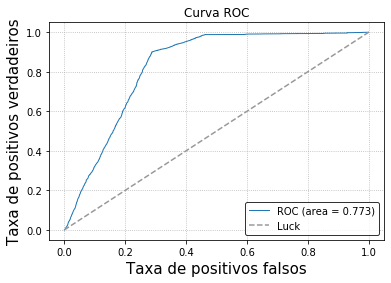

In [19]:
IF_best = clf.best_estimator_
Y_predicted = IF_best.predict(X_eval)
roc_auc = roc_auc_score(Y_eval, Y_predicted)

print(classification_report(Y_eval,
                            Y_predicted,
                            target_names=["anomalous", "normal"]))
print("Área sobre a curva ROC: {:0.3f}".format(roc_auc))

# Computar a curva ROC e a área sob a curva
IF_probs = IF_best.decision_function(X_eval)
fpr, tpr, thresholds = roc_curve(Y_eval, IF_probs)

plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.3f)'%(roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Taxa de positivos falsos', fontsize=15)
plt.ylabel('Taxa de positivos verdadeiros', fontsize=15)
plt.title('Curva ROC', fontsize=12)
plt.legend(loc="lower right", frameon = True).get_frame().set_edgecolor('black')
plt.grid(True, linestyle = 'dotted')
plt.show()

In [20]:
from sklearn.metrics import confusion_matrix
cnf_matrix_IF = confusion_matrix(Y_eval, Y_predicted)
print(cnf_matrix_IF)

[[ 2082  1464]
 [ 1422 32810]]


Eu também vou traçar o limite de decisão aqui.

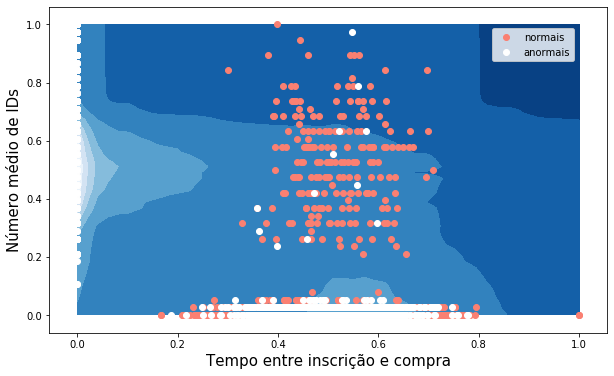

In [23]:
# Definindo tamanho da figura
plt.figure(figsize=(10,6))

# Plotando as linhas de contorno
xx, yy = np.meshgrid(np.linspace(0, 1, 50), np.linspace(0, 1, 50))
Z = IF_best.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

# Plotar dados normais e anômalos
plt.scatter(X_eval[Y_eval==1].tempo, X_eval[Y_eval==1].media_id, 
            color="salmon", label="normais")
plt.scatter(X_eval[Y_eval==-1].tempo, X_eval[Y_eval==-1].media_id, 
            color="white", label="anormais")

# Definir rótulos e legenda
plt.xlabel('Tempo entre inscrição e compra', fontsize=15)
plt.ylabel('Número médio de IDs', fontsize=15)
for text in plt.legend(bbox_to_anchor=(.95, .95)).get_texts():
    text.set_color("black")

Agora vou tentar a abordagem não supervisionada. Nesta abordagem, um algoritmo é alimentado apenas com dados normais, isto é, sem anomalias no mesmo. A partir disso, ele aprende um limite de decisão em torno dos dados normais e, em seguida, classifica novos dados como semelhantes ou diferentes do conjunto de treinamento.

Como esse algoritmo não é supervisionado, a divisão do conjunto de dados é um pouco fora do padrão. Todas as anomalias devem estar apenas nos conjuntos de validação cruzada e avaliação. O modelo aprenderá um limite de decisão em torno dos dados normais e, em seguida, tentará identificar anomalias por sua distância N-dimensional a partir do interior desse limite. Os conjuntos de validação e avaliação cruzada consistem em uma mistura de instâncias normais e anômalas. Não parece que o scikit-learn forneça esse tipo de divisão, então eu farei isso aqui à mão.

In [19]:
# Adicione o vetor de destino de volta ao conjunto de recursos
X["fraude"] = Y

# Separe as anomalias das normais
X_anomalies = X[ X["fraude"] == 1 ]
X_normals = X[ X["fraude"] == 0 ]

# Amostra aleatória de 70% dos índices do conjunto de dados normal para treinamento
train_idxs = sample(list(X_normals.index), int(0.7 * X_normals.shape[0]))
X_train = X_normals.loc[train_idxs]

# Guarde o resto para o conjunto de testes
X_testing = X_normals.drop(train_idxs)

# O conjunto de testes deve agora ser a combinação das instâncias normais restantes que não estão no conjunto de treinamento
# e as instâncias de anomalia
X_testing = pd.concat([X_testing, X_anomalies], axis=0)

# Embaralhe as linhas para ambos os conjuntos de dados
X_train = X_train.sample(frac=1).reset_index(drop=True)
X_testing = X_testing.sample(frac=1).reset_index(drop=True)

#Divida o dataframe de teste em conjuntos de dados de validação cruzada e de avaliação
Y_testing = X_testing["fraude"]
X_testing = X_testing[ [col for col in X_testing.columns if col != "fraude"] ]
X_cv, X_eval, Y_cv, Y_eval = train_test_split(X_testing, Y_testing, train_size=.7, random_state=23)

# Mapeie os valores Y_cv e Y_val para a convenção 1 (normal), -1 (anomalias)
Y_cv = Y_cv.apply(lambda x: 1 if x == 0 else -1)
Y_eval = Y_eval.apply(lambda x: 1 if x == 0 else -1)

# Finalmente, exclua a coluna de classe do conjunto de treinamento
X_train = X_train[ [col for col in X_testing.columns if col != "fraude"] ]

/home/sarinha/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Agora, eu encaixo os hiperparâmetros usando validação cruzada. Primeiro, escolho um conjunto aleatório de hiperparâmetros. Usando este conjunto, eu então encaixo o modelo SVM de uma classe nos dados de treinamento e uso este modelo ajustado para prever os valores do vetor alvo do conjunto de validação cruzada. Em seguida, uso a pontuação F1 para otimizar simultaneamente a precisão e a recordação, comparando minhas previsões com os valores verdadeiros do solo.

In [25]:
# Defina a grade de parâmetros para pesquisar mais
param_grid = {"nu": np.linspace(0.001, .01, 5), "gamma": [0.01, .03, 0.1, 0.3]}
param_list = list(itertools.product(param_grid["nu"], param_grid["gamma"]))

def random_gridsearch(param_list, n_sample, X_train, X_cv, Y_cv):

    f1_max = 0
    param_list = sample(param_list, n_sample)
    remaining_fits = n_sample
    print("Performando {} fits...\n".format(remaining_fits))
    for params in param_list:
        # Initialize class and set hyperparameters
        nu, gamma = params
        OCSVM = OneClassSVM(kernel="rbf", nu=nu, gamma=gamma, random_state=1)

        # Fit model
        print("Fitando o modelo...")
        OCSVM.fit(X_train)

        # Calculate F1 score
        cv_preds = OCSVM.predict(X_cv)
        f1 = f1_score(Y_cv.values, cv_preds, average="binary")

        # Print results
        print("F1 score baseado em nu={0:.3f}, gamma={1:.2f}: {2:.3f}".format(nu, gamma, f1))

        # Optimize for F1 score
        if f1 > f1_max:
            f1_max = f1
            OCSVM_best = OCSVM

        remaining_fits -= 1
        print("Faltam {} fits ...".format(remaining_fits))
        
    return f1_max, OCSVM_best
        
f1_max, OCSVM_best = random_gridsearch(param_list, 10, X_train, X_cv, Y_cv)

Performando 10 fits...

Fitando o modelo...


/home/sarinha/.local/lib/python3.6/site-packages/sklearn/svm/classes.py:1185: DeprecationWarning: The random_state parameter is deprecated and will be removed in version 0.22.
  " be removed in version 0.22.", DeprecationWarning)


F1 score baseado em nu=0.006, gamma=0.10: 0.923
Faltam 9 fits ...
Fitando o modelo...


/home/sarinha/.local/lib/python3.6/site-packages/sklearn/svm/classes.py:1185: DeprecationWarning: The random_state parameter is deprecated and will be removed in version 0.22.
  " be removed in version 0.22.", DeprecationWarning)


F1 score baseado em nu=0.010, gamma=0.30: 0.922
Faltam 8 fits ...
Fitando o modelo...


/home/sarinha/.local/lib/python3.6/site-packages/sklearn/svm/classes.py:1185: DeprecationWarning: The random_state parameter is deprecated and will be removed in version 0.22.
  " be removed in version 0.22.", DeprecationWarning)


F1 score baseado em nu=0.001, gamma=0.01: 0.926
Faltam 7 fits ...
Fitando o modelo...


/home/sarinha/.local/lib/python3.6/site-packages/sklearn/svm/classes.py:1185: DeprecationWarning: The random_state parameter is deprecated and will be removed in version 0.22.
  " be removed in version 0.22.", DeprecationWarning)


F1 score baseado em nu=0.006, gamma=0.30: 0.923
Faltam 6 fits ...
Fitando o modelo...


/home/sarinha/.local/lib/python3.6/site-packages/sklearn/svm/classes.py:1185: DeprecationWarning: The random_state parameter is deprecated and will be removed in version 0.22.
  " be removed in version 0.22.", DeprecationWarning)


F1 score baseado em nu=0.003, gamma=0.01: 0.924
Faltam 5 fits ...
Fitando o modelo...


/home/sarinha/.local/lib/python3.6/site-packages/sklearn/svm/classes.py:1185: DeprecationWarning: The random_state parameter is deprecated and will be removed in version 0.22.
  " be removed in version 0.22.", DeprecationWarning)


F1 score baseado em nu=0.008, gamma=0.01: 0.923
Faltam 4 fits ...
Fitando o modelo...


/home/sarinha/.local/lib/python3.6/site-packages/sklearn/svm/classes.py:1185: DeprecationWarning: The random_state parameter is deprecated and will be removed in version 0.22.
  " be removed in version 0.22.", DeprecationWarning)


F1 score baseado em nu=0.003, gamma=0.10: 0.924
Faltam 3 fits ...
Fitando o modelo...


/home/sarinha/.local/lib/python3.6/site-packages/sklearn/svm/classes.py:1185: DeprecationWarning: The random_state parameter is deprecated and will be removed in version 0.22.
  " be removed in version 0.22.", DeprecationWarning)


F1 score baseado em nu=0.001, gamma=0.10: 0.926
Faltam 2 fits ...
Fitando o modelo...


/home/sarinha/.local/lib/python3.6/site-packages/sklearn/svm/classes.py:1185: DeprecationWarning: The random_state parameter is deprecated and will be removed in version 0.22.
  " be removed in version 0.22.", DeprecationWarning)


F1 score baseado em nu=0.003, gamma=0.03: 0.924
Faltam 1 fits ...
Fitando o modelo...


/home/sarinha/.local/lib/python3.6/site-packages/sklearn/svm/classes.py:1185: DeprecationWarning: The random_state parameter is deprecated and will be removed in version 0.22.
  " be removed in version 0.22.", DeprecationWarning)


F1 score baseado em nu=0.001, gamma=0.03: 0.926
Faltam 0 fits ...


Aqui eu imprimo o relatório de classificação completo e produzo a curva ROC.

/home/sarinha/.local/lib/python3.6/site-packages/sklearn/svm/classes.py:1185: DeprecationWarning: The random_state parameter is deprecated and will be removed in version 0.22.
  " be removed in version 0.22.", DeprecationWarning)


              precision    recall  f1-score   support

    anormais       0.99      0.53      0.69      4192
     normais       0.86      1.00      0.93     12380

    accuracy                           0.88     16572
   macro avg       0.93      0.77      0.81     16572
weighted avg       0.90      0.88      0.87     16572

Área sobre a curva ROC: 0.765


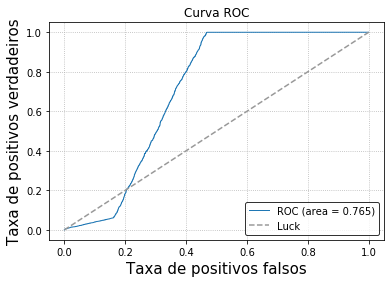

In [26]:
OCSVM_best.fit(X_train)
Y_predicted = OCSVM_best.predict(X_eval)
roc_auc = roc_auc_score(Y_eval, Y_predicted)

print(classification_report(Y_eval, 
                            Y_predicted,
                            target_names=["anormais", "normais"]))
print("Área sobre a curva ROC: {:0.3f}".format(roc_auc))

# Compute a curva ROC e a área sob a curva
OCSVM_probs = OCSVM_best.decision_function(X_eval)
fpr, tpr, thresholds = roc_curve(Y_eval, OCSVM_probs)

plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.3f)'%(roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Taxa de positivos falsos', fontsize=15)
plt.ylabel('Taxa de positivos verdadeiros', fontsize=15)
plt.title('Curva ROC', fontsize=12)
plt.legend(loc="lower right", frameon = True).get_frame().set_edgecolor('black')
plt.grid(True, linestyle = 'dotted')
plt.show()

In [27]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_eval, Y_predicted))   

[[ 2230  1962]
 [   13 12367]]


Eu também vou traçar o limite de decisão aqui.

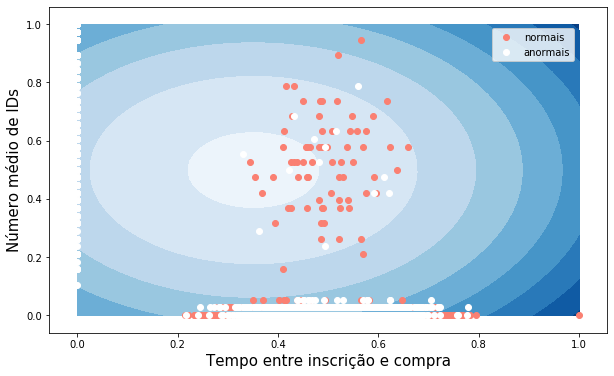

In [28]:
# Definir tamanho da figura
plt.figure(figsize=(10,6))

# Traçar as linhas de contorno
xx, yy = np.meshgrid(np.linspace(0, 1, 50), np.linspace(0, 1, 50))
Z = OCSVM_best.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

# Plotar dados normais e anômalos
plt.scatter(X_eval[Y_eval==1].tempo, X_eval[Y_eval==1].media_id, 
            color="salmon", label="normais")
plt.scatter(X_eval[Y_eval==-1].tempo, X_eval[Y_eval==-1].media_id, 
            color="white", label="anormais")

# Definir rótulos e legenda
plt.xlabel('Tempo entre inscrição e compra', fontsize=15)
plt.ylabel('Número médio de IDs', fontsize=15)
for text in plt.legend(bbox_to_anchor=(.95, .95)).get_texts():
    text.set_color("black")

## Conclusões parciais

**Observações**:
* Nem todos os endereços IP do conjunto de dados podem ser rastreados para um país de origem. Independentemente disso, parece que o país de origem não desempenha um papel significativo na identificação de fraudes, por isso não importa realmente.
* Construi dois modelos:
    * Floresta de isolamento: um alogoritmo supervisionado baseado na análise de quantas divisões em recursos são necessárias para isolar uma determinada amostra.
    * Uma máquina de vetores de suporte de classe: um algoritmo não supervisionado baseado no aprendizado de um limite de decisão em torno de dados não anômalos e, em seguida, na tentativa de identificar anomalias determinando sua distância a partir desse limite.
* Para otimizar a precisão e a recordação simultaneamente, decidi otimizar a pontuação F1 em vez da precisão. Usando esse método de otimização, descobri que **a floresta de isolamento tem um desempenho melhor do que a classe SVM**. O SVM tem uma precisão muito alta para identificar fraudes, mas um recall relativamente baixo por fraude. Isso indica para mim que o SVM está simplesmente adivinhando fraude com mais frequência do que a floresta de isolamento. Esse entendimento é apoiado por parcelas dos limites de decisão. O SVM gera um limite de decisão circular devido ao kernel da função de base radial, mas isso não permite muita flexibilidade em face de um espaço de recurso não-gaussiano e multi-modal. A floresta de isolamento é muito mais flexível e, portanto, mesmo que suas pontuações não sejam drasticamente diferentes, espero generalizar muito melhor do que a SVM para dados adicionais.
* As características mais importantes, em ordem de importância, para detectar fraudes foram determinadas como:
    * A velocidade na qual eles se movimentaram por todo o funil de vendas (da inscrição à compra).
    * Se ou não vários IDs de usuário foram gerados a partir de um único dispositivo ou endereço IP.


### AULA 5

Se analisarmos as matrizes de confusão, veremos uma informação muito importante:
* O método supervisionado (floresta de isolaento) identificou 1450 casos que eram fraude como não-fraude. Isso se torna extremamente perigoso, uma vez que existe um custo associado às fraudes. 
* O método não supervisionado (SVM) identificou 1994 casos que eram fraude como não-fraude, um resultado bem pior. 

Desta forma, observa-se que métodos supervisionados parecem mais adequados. Entretanto, seria a árvore de isolamento a melhor opção? Talvez o uso de isolation forest, uma versão mais complexa de um conjunto de árvores de decisão não seja o mais adequado. Sendo assim, vamos testar o uso de uma árvore de decisão.

              precision    recall  f1-score   support

    anormais       0.92      0.84      0.88      4204
     normais       0.95      0.98      0.96     12368

    accuracy                           0.94     16572
   macro avg       0.94      0.91      0.92     16572
weighted avg       0.94      0.94      0.94     16572

Área sobre a curva ROC: 0.909


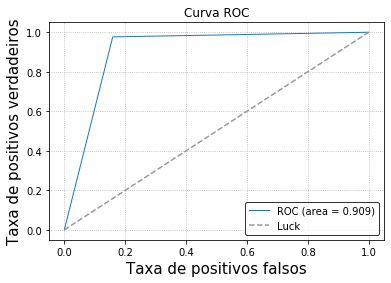

In [22]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(random_state=1)
decision_tree.fit(X_dev,Y_dev)

Y_predicted = decision_tree.predict(X_eval)
roc_auc = roc_auc_score(Y_eval, Y_predicted)

cv_preds = decision_tree.predict(X_cv)
print(classification_report(Y_eval, 
                            Y_predicted,
                            target_names=["anormais", "normais"]))
print("Área sobre a curva ROC: {:0.3f}".format(roc_auc))

dt_probs = decision_tree.predict_proba(X_eval)
fpr, tpr, _ = roc_curve(Y_eval, Y_predicted)


plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.3f)'%(roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Taxa de positivos falsos', fontsize=15)
plt.ylabel('Taxa de positivos verdadeiros', fontsize=15)
plt.title('Curva ROC', fontsize=12)
plt.legend(loc="lower right", frameon = True).get_frame().set_edgecolor('black')
plt.grid(True, linestyle = 'dotted')
plt.show()


In [23]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_eval, Y_predicted))  

[[ 3535   669]
 [  291 12077]]


Percebe-se que, neste caso, menos de 700 casos que eram fraude não foram identificados. Da mesma forma, pouco mais de 200 casos que não eram fraude foram identificados como fraude. Um resultado excelente! 


**Recomendações**:   
Eu recomendo implementar o modelo de árvore de decisão em produção. Eu também tenho duas recomendações específicas para a equipe de experiência do usuário e uma para a equipe de segurança.


1. Certifique-se de exigir o nome completo e endereço de e-mail de um usuário para se inscrever. Quando um usuário esquecer seu nome de usuário / senha, dê a ele um caminho fácil de seguir para **redefinir** sua senha e exigir seu nome completo e endereço de e-mail para fazer isso. Dessa forma, o ID do usuário original do usuário pode ser encontrado no banco de dados e excluído antes de fornecer um novo ID de usuário. Isso minimiza as chances de um usuário normal ter vários IDs de usuário e reduz as chances de confundi-los com um fraudador.
2. Depois que um usuário se inscrever, apresente imediatamente ofertas / descontos em potencial, se possível. Isso pode ser anunciado como um simples agradecimento por você se inscrever, mas, para usuários normais, aumentará as chances de compra e, ao mesmo tempo, dará a eles algo a considerar, diminuindo um pouco a velocidade deles, dificultando confundi-los com eles. um bot que provavelmente ignoraria todas as ofertas de descontos.
3. Também recomendo enfaticamente aumentar a segurança durante as primeiras três semanas do ano, pois parece haver um pico de atividade fraudulenta durante esse período.



**Observações**

Note que poderíamos utilizar a função GridSearch também no algoritmo de árvore de decisões. Entretanto, GridSearchCV vai usar uma (ou mais) métricas para determinar o melhor modelo, mas não necessariamente vai ver qual o modelo que identifica melhor as fraudes.É digno de nota que se entenda que nem sempre devemos apenas seguir o protocolo, mas também podemos sair dele, caso nosso problema demande algo mais específico.